# Project 6 : TEXT MINING - Online_Job_Postings_Analysis

##### By Nitin Rana - rnitin25@gmail.com

In [1]:
# basic imports 
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
#use this for preprocessing 
import nltk.classify.util
from nltk.corpus import stopwords   # remove stopwords from the text 
from nltk.tokenize import word_tokenize # split the words
from nltk.corpus import wordnet  # finding similar opposite of words # finding meaning out of the words
from nltk import pos_tag
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk

# gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import joblib

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split, GridSearchCV#split the data
#classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

#wordcloud
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

In [3]:
data = pd.read_csv("E:/BA 360/Case Studies & Assignments/Python Projects/6. Analyzing online Job Postings/data job posts.csv")

## Data Understanding 

* ##### See how Frequency of job post distributed yearly

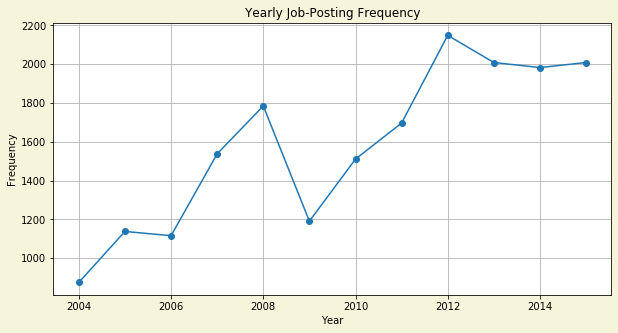

In [56]:
plt.figure(figsize =(10,5), facecolor='beige')
plt.title("Yearly Job-Posting Frequency")
plt.plot(data.groupby('Year').jobpost.count().index,data.groupby('Year').jobpost.count(),marker = 'o')
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

* In year 2009, there is sharp fall in the job posting (must be because of Global Financial Crisis of 2007)
* otherwise frequency of job posting has been increasing yearly till 2012
* from 2013 onwards ,it has remain constant

* ###### Frequency of job postings by Month

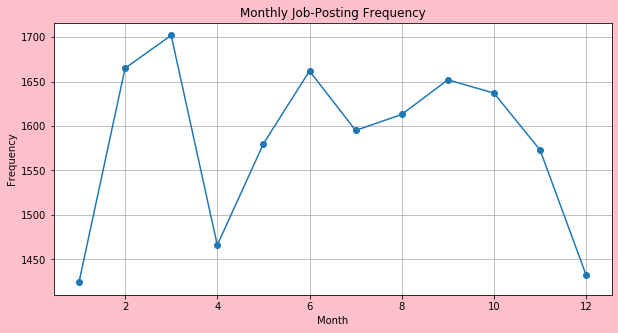

In [57]:
plt.figure(figsize =(10,5), facecolor='pink')
plt.title("Monthly Job-Posting Frequency")
plt.plot(data.groupby('Month').jobpost.count().index,data.groupby('Month').jobpost.count(),marker = 'o')
plt.xlabel("Month")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

* In the month of March , February and June there are more job postings
* while in January and December , there is minimal job postings

* ##### Top 20 companies in terms of Job Postings

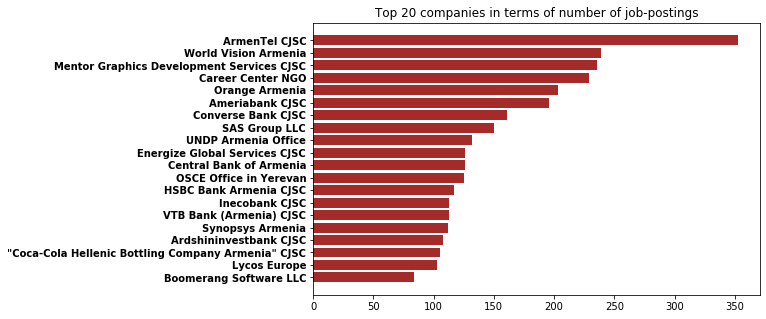

In [58]:
top20comp= data.groupby("Company").jobpost.count().sort_values(ascending = False).head(20).reset_index()
top20comp.sort_values(by='jobpost',inplace = True)
plt.figure(figsize=(8,5))
plt.title("Top 20 companies in terms of number of job-postings")
plt.barh(top20comp.Company, top20comp.jobpost, color = 'brown')
plt.yticks(fontweight = 'bold')
plt.show()

##### Length of jobpost for each entry

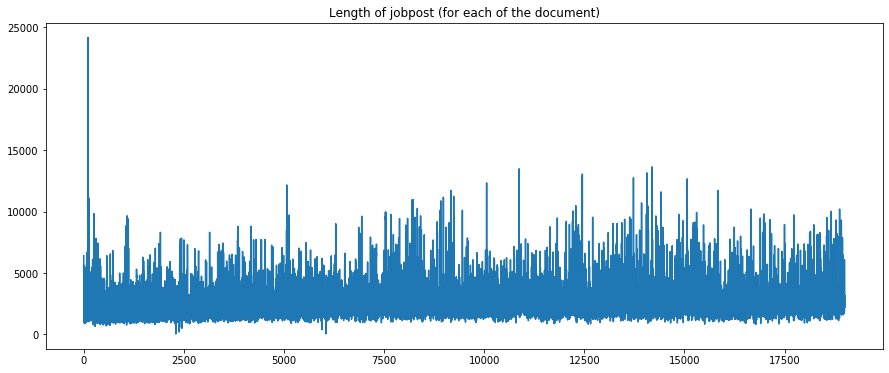

In [65]:
plt.figure(figsize=(15, 6))
plt.plot(data.jobpost.apply(len))
plt.title('Length of jobpost (for each of the document)')
plt.show()

In [74]:
len(data.jobpost[105])

24184

    * most of jobpost are under 10000 words bracket except jobpost at index 105 with title  'Annual Program Statement'  with length of approx 24000
    
    
  -------------------------------------------------------

### Data Cleaning

In [4]:
# Stopwords Preparation
stop_words = list(set(stopwords.words('english')))
#extend the stopwords list with some new words
stop_words.extend(['armenian','armenia','job','title','position','location','responsibilities','application','procedures',
             'deadline','required','qualification','renumeration','salary','date','company','llc','use','department','the',
                'new','from','subject','edu'])

In [45]:
def pre_process(sentence):
    sentence = re.sub(r'\s+[a-z]\s+', ' ',sentence)
    sentence = re.sub(r'^[a-z]\s+', ' ', sentence)
    cleaned_sentence = re.sub(r'\s+', ' ', sentence)
        
    # tokenization and remove punctuations
    List_of_words = gensim.utils.simple_preprocess(str(cleaned_sentence),
                                                   deacc=True , min_len= 4) # deacc=True removes punctuations
                                                                            # min_len will remove all token less than 4
    #remove stopwords
    word_nostops = [word for word in List_of_words if word not in stop_words]
    return word_nostops

In [46]:
def make_bigrams(doc):
    # Build the bigram model
    bigram = gensim.models.Phrases(doc, min_count=3, threshold=100) 
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod[doc]

def make_trigrams(doc):
    # Build the bigram model
    trigram = gensim.models.Phrases(doc, threshold=100)   
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    return trigram_mod[doc]

def lemmatization(tokens, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    lemma = WordNetLemmatizer()
    #tokens = word_tokenize(texts)
    lemmatize_text = [lemma.lemmatize(word) for word in tokens]
    #tokens = word_tokenize(lemmatize_text)
    #lemmatize_text = " ".join([x for x in tokens if x != []] ) # to remove some null values created by lemmatization
    return lemmatize_text

def list_to_text(List_of_words):
    text = " ".join([word for word in List_of_words])
    return text

-----------------------------------------------------------------------------------------------------------------
# 1. Unsupervised Learning

----------------------------------------------------------------------------------------------------
* ## 1.1 : K-Means Clustering
       
    ### Objective - Desired Characteristics & skill-sets

     To have global understanding of the required qualification for the job postings and understand how these qualifications have changed over the time-period evaluated the records is going to be clustered based on the content of the **Required Qualification** column.

In [7]:
data_qual = data.drop_duplicates(['RequiredQual'])  #removing duplicates of required qual column
data_qual = data_qual[['RequiredQual','Year']] # extracting qualification and year column from original dataset 
data_qual = data_qual.dropna() # removing na row
print(data_qual.shape)
print("Removed {0} duplicates & NA's (based on RequiredQual column)".format(data.shape[0]-data_qual.shape[0]))

(16688, 2)
Removed 2313 duplicates & NA's (based on RequiredQual column)


In [8]:
# preprocess RequiredQual column
data_qual['RequiredQual'] = data_qual.RequiredQual.apply(lambda x: pre_process(x)) #tokenize,remove punctuation & stopwords
data_qual['RequiredQual'] = data_qual.RequiredQual.apply(lambda x: make_bigrams(x)) # bigrams
data_qual['RequiredQual'] = data_qual.RequiredQual.apply(lambda x: make_trigrams(x)) # trigrams
data_qual['RequiredQual'] = data_qual.RequiredQual.apply(lambda x: lemmatization(x))  #lemmatization

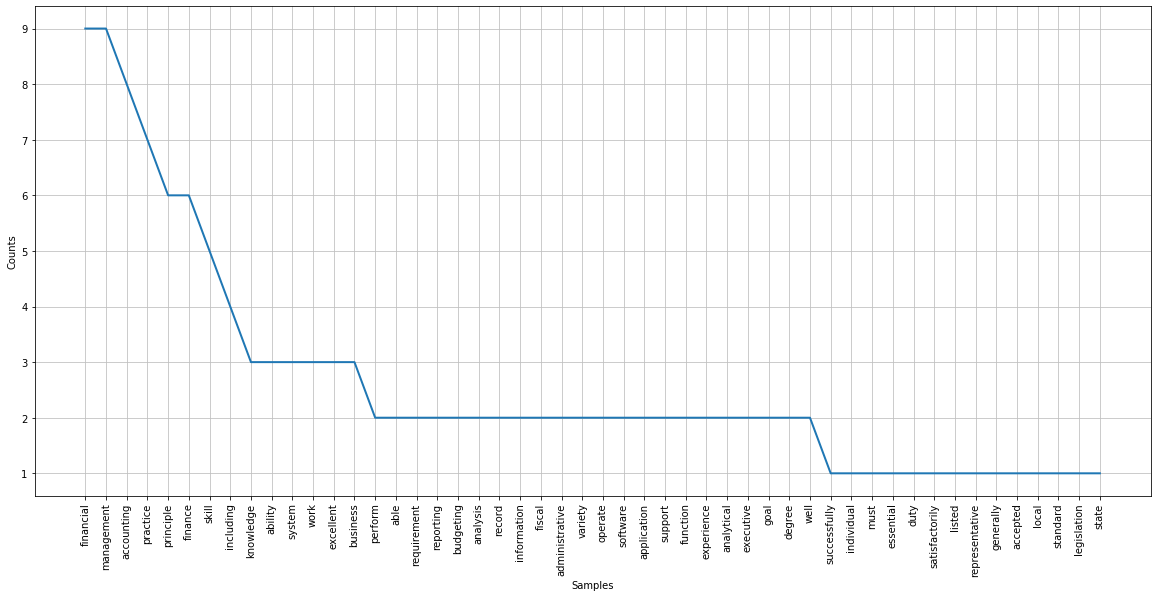

In [9]:
# plot effect of preprocessing on the a sample column
plt.figure(figsize=(20, 9))
fd = nltk.FreqDist(data_qual.RequiredQual[0])  # case sensitive!
fd.most_common(50)
fd.plot(50)
plt.show()

    Here we can clearly see the effect of preprocessing and stopwords removal on the sample column
    Also, with gensim_preprocessing we have limit the length of word to more than 3 words , thus we cannot see words of less than 4 chars

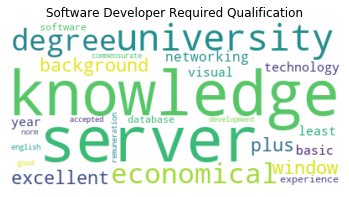

In [10]:
# lets see qualification for a software developer i.e. indexed at 4
wc = WordCloud(background_color="white").generate(list_to_text(data_qual.RequiredQual[4]))
plt.title("Software Developer Required Qualification")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

     now that we are satisfied with the preprocessing of the column , we can use the data_qual to perform clustering

In [11]:
# convert the columns contain lists of documents to text for vectorization
data_qual["RequiredQual_text"] = data_qual.RequiredQual.apply(lambda x: list_to_text(x))

In [11]:
tfidf_vect = TfidfVectorizer( analyzer='word',
                             max_df=0.7,    # vocab if available in more than 70% docs , then ignored
                             min_df=3,      # vocab if available in less than 3 docs , then ignored
                             stop_words='english')

qual_tfidf = tfidf_vect.fit_transform(data_qual.RequiredQual_text)    #tfidf matrix
qual_features = tfidf_vect.get_feature_names()  # get feature names
qual_dtm = pd.DataFrame(qual_tfidf.toarray(), columns=tfidf_vect.get_feature_names()) # create document term matrix
qual_dtm.shape

(16688, 4809)

    for tfidf matrix , we have ignored the vocabs which are available in more than 70% of the documents and in less than  3 documents 
    The dimension of the resulting matrix is (16688, 4809) , where 13083 is the number of job postings and 4674 is the number of terms in TFIDF matrix
    
###### reducing dimension through Singular Value Decomposition

In [12]:
svd = TruncatedSVD(n_components=1500)
normalizer = Normalizer(copy=False)
svd_pipe = make_pipeline(svd, normalizer)
X_svd = svd_pipe.fit_transform(qual_tfidf)

In [14]:
svd.explained_variance_ratio_.sum()

0.9090690021201813

     After SVD , almost 90% of data variance could be explained by 1500 components. Thus, using these components to perform Kmeans clustering

In [15]:
# lets find top words for each components
svd_components = []
Top_10_Key_Terms = []

for i, comp in enumerate(svd.components_):
    termsincomp = zip(qual_features, comp)
    sortedterms = sorted(termsincomp, key = lambda x: x[1],reverse=True)[:10] # get top 10 keywords from each components
    svd_components.append("comp_" + str(i))
    Top_10_Key_Terms.append([term[0] for term in sortedterms])

svd_components_table = pd.DataFrame({"svd_components" : svd_components , "Keyterms" : Top_10_Key_Terms})
svd_components_table

,svd_components,Keyterms
0,comp_0,"[work, ability, excellent, good, russian, year..."
1,comp_1,"[accounting, finance, banking, economics, russ..."
2,comp_2,"[accounting, finance, software, development, f..."
3,comp_3,"[higher, education, good, plus, programming, s..."
4,comp_4,"[relevant, field, management, project, interna..."
...,...,...
1495,comp_1495,"[microfinancial, male, electricity, interactin..."
1496,comp_1496,"[altitude, interacting, automotive, disciplina..."
1497,comp_1497,"[outsourcing, male, careful, turkish, actionsc..."
1498,comp_1498,"[civic, fourth, notion, cooking, automobile, s..."


###### Find best value of clusters in Kmeans Clustering with 1500 svd components with range of clusters from 4 to 10 

In [18]:
# function to get silhoute score , errors and model output for each of the n_cluster value
def find_best_cluster(data, n_range):
    errors_list = []
    scores_list = []
    model_list = []
    for n in n_range:
        kmeans = KMeans(n_clusters=n, init='k-means++', max_iter=1000, n_init=1, random_state=111, n_jobs=-1)
        model_prediction = kmeans.fit_predict(data)
        center = kmeans.cluster_centers_
        errors_list.append(kmeans.inertia_)
        scores_list.append(metrics.silhouette_score(data, model_prediction))
        model_list.append(kmeans)
    return errors_list, scores_list, model_list 

In [19]:
n_range = range(4,11)    # setting cluster values ranging from 4 to 10
 
errors , scores, models = find_best_cluster(X_svd, n_range=n_range) 

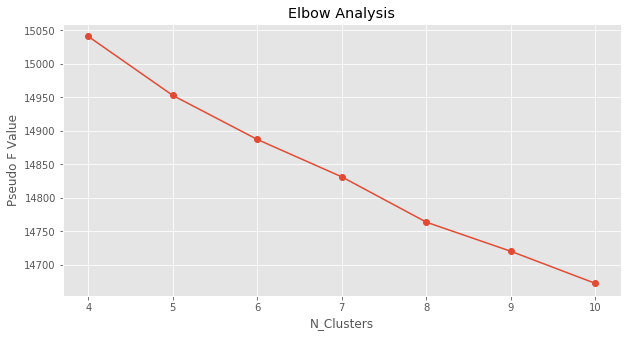

In [20]:
# elbow analysis
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.title("Elbow Analysis")
plt.plot(range(4,11),errors, marker = 'o')
plt.grid(True)
plt.xlabel("N_Clusters")
plt.ylabel("Pseudo F Value")
plt.show()

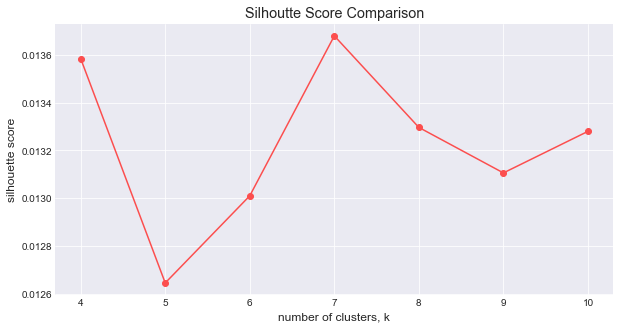

In [22]:
# silhoute score comparison
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10,5))
plt.title("Silhoutte Score Comparison")
plt.plot(range(4,11),scores, '-o', color='#FC4E4E')
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette score')
plt.xticks(range(4,11))
plt.show()

   * From both , Elbow Analysis and comparing silhoutte's coefficients , I have chosen **7 number of clusters**
   
   * lets find out the key terms from each clusters & try to interpret its significance 

In [24]:
optimal_kmeans_model = models[3] # as 7 cluster model is indexed at 3

In [26]:
# saving data and model output
joblib.dump(optimal_kmeans_model ,'best_kmeans_model.pkl')  # saving 

data_qual.to_csv("Required_Qual_dataset.csv") # saving datasets
svd_components_table.to_csv("SVD_comp_table.csv")

In [7]:
data_qual = pd.read_csv("Required_Qual_dataset.csv")
optimal_kmeans_model = joblib.load('best_kmeans_model.pkl')

###### Lets look at the top key terms for distinct interpretation of each cluster

In [13]:
def get_terms_df(kmean_model, cluster_num, svd):
    clusters= []
    terms_per_cluster = []
    centroids = svd.inverse_transform(kmean_model.cluster_centers_)  # get centroids of original data from cluster centeres
    sorted_centroids = centroids.argsort()[:, ::-1]
    terms = tfidf_vect.get_feature_names()     # tfidf vect featurenames
    for i in range(cluster_num):
        clusters.append(i)
        top_10 = []
        for ind in sorted_centroids[i, :10]:
            top_10.append((terms[ind]))
        terms_per_cluster.append(top_10)
            
    #create cluster_dataframe:
    clustered_df = pd.DataFrame({'Cluster_No' : clusters, 'Terms':terms_per_cluster})
    return clustered_df

In [15]:
km7_cluster_df = get_terms_df(optimal_kmeans_model, optimal_kmeans_model.n_clusters, svd)
km7_cluster_df.style.set_properties(subset=['Terms'], **{'width': '600px'})

,Cluster_No,Terms
0,0,"['higher', 'education', 'work', 'excellent', 'russian', 'good', 'ability', 'computer', 'field', 'year']"
1,1,"['accounting', 'finance', 'work', 'financial', 'standard', 'legislation', 'excellent', 'software', 'good', 'year']"
2,2,"['good', 'work', 'ability', 'year', 'degree', 'plus', 'network', 'russian', 'excellent', 'computer']"
3,3,"['marketing', 'sale', 'excellent', 'ability', 'business', 'work', 'russian', 'communication', 'strong', 'degree']"
4,4,"['development', 'good', 'programming', 'ability', 'software', 'plus', 'design', 'work', 'database', 'java']"
5,5,"['ability', 'management', 'project', 'excellent', 'work', 'international', 'development', 'strong', 'degree', 'communication']"
6,6,"['work', 'excellent', 'university', 'ability', 'degree', 'russian', 'good', 'communication', 'field', 'relevant']"


### following are the interpretation for each cluster 
0. Higher Education and Language
1. Accounts and Finance
2. Network
3. Sales and Marketing
4. IT Development
5. Project Management
6. Communication

        Lets add above cluster interpretation in the dataset 

In [16]:
clus_interpretation = ['Higher Education and Language','Accounts and Finance', 'Network', 'Sales & Marketing' ,'IT Development',
                      'Project Management','Communication']
km7_cluster_df['Interpretation'] = clus_interpretation
km7_cluster_df

,Cluster_No,Terms,Interpretation
0,0,"[higher, education, work, excellent, russian, ...",Higher Education and Language
1,1,"[accounting, finance, work, financial, standar...",Accounts and Finance
2,2,"[good, work, ability, year, degree, plus, netw...",Network
3,3,"[marketing, sale, excellent, ability, business...",Sales & Marketing
4,4,"[development, good, programming, ability, soft...",IT Development
5,5,"[ability, management, project, excellent, work...",Project Management
6,6,"[work, excellent, university, ability, degree,...",Communication


In [17]:
# lets add these clusters to the original Required_Qual dataset

data_qual['KM7_clusters'] = optimal_kmeans_model.labels_ # add labels to the dataset

#now add respective terms and Interpretation of each document into the orig dataste
def get_interpret(x):
    reqd_terms = km7_cluster_df.Terms[x]
    reqd_interpret = km7_cluster_df.Interpretation[x]
    return (reqd_terms,reqd_interpret)

data_qual["clus_Keyterms"] = data_qual.KM7_clusters.apply(lambda x: get_interpret(x)[0])
data_qual["clus_Interpretation"]  = data_qual.KM7_clusters.apply(lambda x: get_interpret(x)[1])
data_qual.head()

,RequiredQual,Year,RequiredQual_text,KM7_clusters,clus_Keyterms,clus_Interpretation
0,"['perform', 'successfully', 'individual', 'mus...",2004,perform successfully individual must able perf...,1,"[accounting, finance, work, financial, standar...",Accounts and Finance
1,"['bachelor', 'degree', 'master', 'preferred', ...",2004,bachelor degree master preferred excellent ski...,2,"[good, work, ability, year, degree, plus, netw...",Network
2,"['degree', 'environmentally', 'related', 'fiel...",2004,degree environmentally related field year rele...,2,"[good, work, ability, year, degree, plus, netw...",Network
3,"['advanced', 'degree', 'public', 'health', 'so...",2004,advanced degree public health social science c...,5,"[ability, management, project, excellent, work...",Project Management
4,"['university', 'degree', 'economical', 'backgr...",2004,university degree economical background plus e...,4,"[development, good, programming, ability, soft...",IT Development


In [18]:
data_qual.to_csv("Required_Qual_dataset.csv") # saving datasets
km7_cluster_df.to_csv("km7_cluster_df.csv")

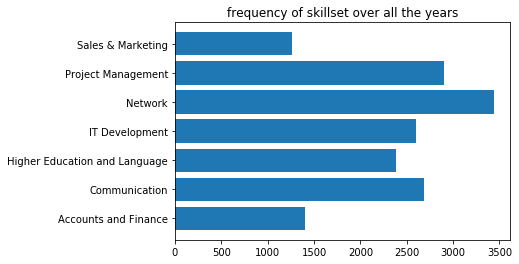

In [19]:
plt.title("frequency of skillset over all the years")
plt.barh(data_qual.groupby('clus_Interpretation').KM7_clusters.count().index,
         data_qual.groupby('clus_Interpretation').KM7_clusters.count())
plt.show()

    * Network and Project Management skills are required in most of the jobs in all the years
    
### 1.1.1 How these Qualification Requirement changes over time :

            For this I am segregating the dataset into three time periods
            2004-2007 , 2008-2011, 2012-2015

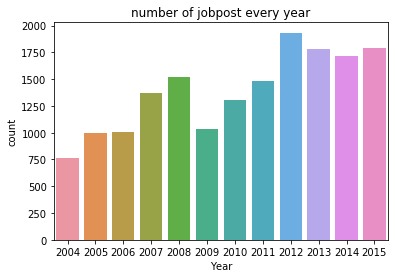

In [20]:
# lets see the distribution of Years 
plt.title("number of jobpost every year")
sns.countplot(x=data_qual.Year)
plt.show()

In [21]:
# define periods
period_1 = range(2004,2007+1)
period_2 = range(2008,2011+1)
period_3 = range(2012,2015+1)

#divide dataset based on the periods
def period_by_year(x):
    if x in period_1:
        return '2004-2007'
    elif x in period_2:
        return '2008-2011'
    elif x in period_3:
        return '2012-2015'
data_qual['period'] = data_qual.Year.apply(lambda x: period_by_year(x))

df_p1 = data_qual.loc[data_qual.period == '2004-2007',['RequiredQual_text','period']]
df_p2 = data_qual.loc[data_qual.period == '2008-2011',['RequiredQual_text','period']]
df_p3 = data_qual.loc[data_qual.period == '2012-2015',['RequiredQual_text','period']]

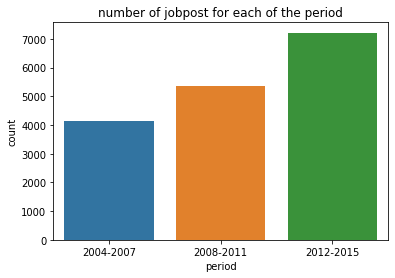

In [22]:
plt.title("number of jobpost for each of the period")
sns.countplot(x=data_qual.period)
plt.show()

###### perform clustering with 7 n_clusters for each of the period of dataset

In [25]:
def get_clusters_time_period(X, data , clusters):
    #tf_idf_vectorizer
    vect = TfidfVectorizer(max_df=0.7, min_df=3)
    X_tf = vect.fit_transform(data[X])
    
    # Use SVD to reduce dimensions
    SVD = TruncatedSVD(n_components=1000)
    norm = Normalizer(copy=False)
    pipe = make_pipeline(SVD, norm)
    x_svd = pipe.fit_transform(X_tf)
    
    explained_variance = SVD.explained_variance_ratio_.sum()  # get explained variance by svd
    print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))
    
    #kmeans clustering
    km = KMeans(n_clusters=clusters, init='k-means++', max_iter=1000, n_init=1, random_state=100 , n_jobs = -1)
    km.fit(x_svd)
    
    #adding labels in the data
    data['clusters'] = km.labels_
    
    #getting clustered df
    clusters_list= []
    terms_per_cluster = []
    centroids = SVD.inverse_transform(km.cluster_centers_)  # get centroids of original data from cluster centeres
    sorted_centroids = centroids.argsort()[:, ::-1]
    terms = vect.get_feature_names()     # tfidf vect featurenames
    for i in range(clusters):
        clusters_list.append(i)
        top_10 = []
        for ind in sorted_centroids[i, :10]:
            top_10.append((terms[ind]))
        terms_per_cluster.append(top_10)
            
    #create cluster_dataframe:
    clustered_df = pd.DataFrame({'Cluster_No' : clusters_list, 'Terms':terms_per_cluster})
    return clustered_df

###### Qualification Requirement for Period_1 - 2004-2007

In [26]:
km7_df_period_1 = get_clusters_time_period(X = 'RequiredQual_text', data=df_p1 ,clusters= 7 )
km7_df_period_1.style.set_properties(subset=['Terms'], **{'width': '600px'})

Explained variance of the SVD step: 93%


,Cluster_No,Terms
0,0,"['accounting', 'finance', 'financial', 'standard', 'software', 'work', 'skill', 'year', 'excellent', 'good']"
1,1,"['development', 'programming', 'server', 'java', 'software', 'ability', 'year', 'work', 'system', 'good']"
2,2,"['skill', 'excellent', 'ability', 'work', 'good', 'communication', 'strong', 'russian', 'degree', 'university']"
3,3,"['work', 'year', 'good', 'skill', 'degree', 'ability', 'plus', 'russian', 'driving', 'university']"
4,4,"['higher', 'education', 'skill', 'excellent', 'work', 'russian', 'good', 'computer', 'field', 'communication']"
5,5,"['management', 'skill', 'project', 'ability', 'international', 'work', 'development', 'year', 'degree', 'training']"
6,6,"['relevant', 'field', 'work', 'university', 'skill', 'degree', 'excellent', 'year', 'computer', 'good']"


In [27]:
km7_df_period_1['Interpretation'] = ['Accounts and Finance', 'IT Development','Communication','clus_3' ,'Higher Education and Language',
                                     'Project Management','Computers']

In [28]:
df_p1['clus_interpretation'] = df_p1.clusters.apply(lambda x: km7_df_period_1.Interpretation[x])

In [31]:
df_p1.to_csv("df_period1.csv") # saving dataset
km7_df_period_1.to_csv("km7_df_period_1.csv")

###### Qualification Requirement for Period_2 - 2008-2011

In [32]:
km7_df_period_2 = get_clusters_time_period(X = 'RequiredQual_text', data=df_p2 ,clusters= 7 )
km7_df_period_2.style.set_properties(subset=['Terms'], **{'width': '600px'})

Explained variance of the SVD step: 91%


,Cluster_No,Terms
0,0,"['professional', 'intermediate', 'profound', 'central', 'case', 'elsewhere', 'bank', 'work', 'year', 'higher']"
1,1,"['accounting', 'finance', 'work', 'good', 'standard', 'software', 'financial', 'banking', 'year', 'legislation']"
2,2,"['ability', 'management', 'work', 'degree', 'good', 'excellent', 'year', 'project', 'international', 'field']"
3,3,"['responsibility', 'sense', 'high', 'work', 'ability', 'excellent', 'russian', 'communication', 'good', 'strong']"
4,4,"['excellent', 'work', 'ability', 'russian', 'university', 'degree', 'marketing', 'communication', 'sale', 'office']"
5,5,"['higher', 'education', 'good', 'excellent', 'banking', 'russian', 'work', 'field', 'computer', 'ability']"
6,6,"['development', 'good', 'ability', 'design', 'software', 'programming', 'database', 'work', 'technology', 'year']"


In [33]:
km7_df_period_2['Interpretation'] = ['Banking' , 'Accounts and Finance', 'Project Management','Communication','Sales & Marketing' ,
                                     'Higher Education and Language','IT Development']

In [34]:
df_p2['clus_interpretation'] = df_p2.clusters.apply(lambda x: km7_df_period_2.Interpretation[x])

In [35]:
df_p2.to_csv("df_period2.csv") # saving dataset
km7_df_period_2.to_csv("km7_df_period_2.csv")

###### Qualification Requirement for Period_3 - 2012-2015

In [36]:
km7_df_period_3 = get_clusters_time_period(X = 'RequiredQual_text', data=df_p3 ,clusters= 7 )
km7_df_period_3.style.set_properties(subset=['Terms'], **{'width': '600px'})

Explained variance of the SVD step: 88%


,Cluster_No,Terms
0,0,"['adobe', 'photoshop', 'illustrator', 'design', 'draw', 'corel', 'indesign', 'graphic', 'work', 'ability']"
1,1,"['testing', 'test', 'tool', 'software', 'development', 'ability', 'assurance', 'methodology', 'good', 'asset']"
2,2,"['ability', 'work', 'management', 'excellent', 'degree', 'good', 'project', 'year', 'communication', 'least']"
3,3,"['development', 'good', 'plus', 'html', 'framework', 'programming', 'javascript', 'technology', 'design', 'database']"
4,4,"['accounting', 'finance', 'legislation', 'financial', 'work', 'banking', 'economics', 'excellent', 'ability', 'year']"
5,5,"['excellent', 'work', 'ability', 'russian', 'degree', 'university', 'field', 'communication', 'strong', 'marketing']"
6,6,"['education', 'higher', 'work', 'russian', 'excellent', 'ability', 'good', 'field', 'computer', 'year']"


In [83]:
km7_df_period_3['Interpretation'] = ['Graphic Design' , 'IT Operations', 'Project Management','IT Development','Accounts and Finance' ,
                                     'Communication','Higher Education and Language']

In [84]:
df_p3['clus_interpretation'] = df_p3.clusters.apply(lambda x: km7_df_period_3.Interpretation[x])

In [85]:
df_p3.to_csv("df_period3.csv") # saving dataset
km7_df_period_3.to_csv("km7_df_period_3.csv")

     now, lets see the comparison in the skillsets over the different periods

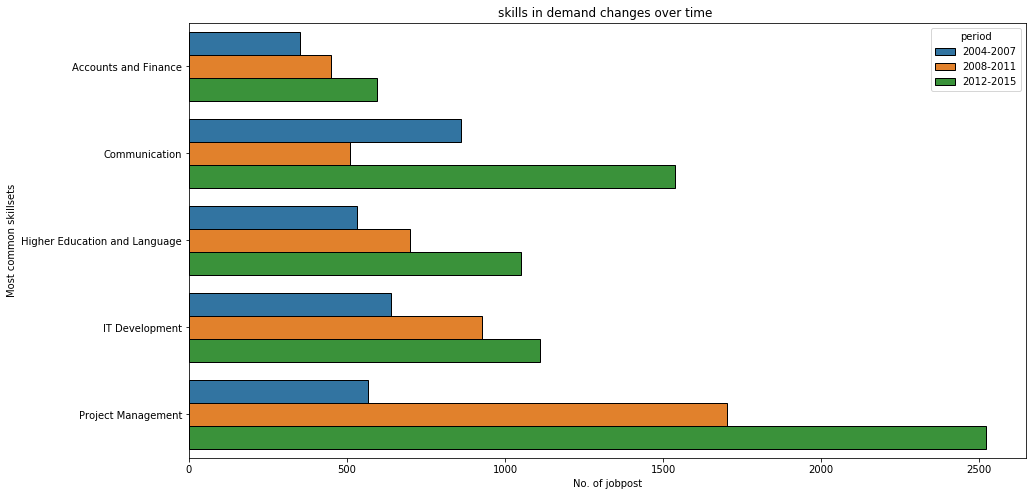

In [88]:
# combine all three period dataset
vis = pd.concat([df_p1,df_p2,df_p3],axis=0 , ignore_index=True)
vis = vis.groupby(['period','clus_interpretation']).clusters.count().reset_index()
vis = vis[(vis.clus_interpretation == 'Higher Education and Language') |(vis.clus_interpretation == 'Accounts and Finance')|
         (vis.clus_interpretation == 'Communication')|(vis.clus_interpretation == 'Project Management')|(vis.clus_interpretation == 'IT Development')]

plt.figure(figsize=(15,8))
plt.title("skills in demand changes over time ")
sns.barplot(x= 'clusters',y ='clus_interpretation',hue = 'period' ,data= vis, ec = 'black')
plt.xlabel("No. of jobpost")
plt.ylabel("Most common skillsets")
plt.show()

    Management & Communication skills have been growing a lot in the latest period , while almost every skills have                 grown over all the years

--------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
* ## 1.2 : Topic Modelling - LDA
       
    ### Objective - Job Nature and Company Profiles

     To see what types of jobs that are in demand in Armenia & also how are the job natures changing over time .
     
     We use gensim's LDA model class to do Latent Dirichlet Allocation(LDA) for topic modelling on **jobpost** column

###### preprocess jobpost column

In [92]:
# extracting useful columns from the dataset for further analysis
job_data = data.loc[:,['jobpost', 'Title', 'JobDescription', 'JobRequirment', 'RequiredQual','AboutC', 'Year', 'IT']]

In [93]:
job_data = job_data.drop_duplicates(subset=['jobpost','Title']) 

print("Removed {0} duplicates (based on jobpost & Title column)".format(data.shape[0]-job_data.shape[0]))

Removed 109 duplicates (based on jobpost & Title column)


In [94]:
# preprocess jobpost column
job_data['jobpost'] = job_data.jobpost.apply(lambda x: pre_process(x)) #tokenize,remove punctuation & stopwords
job_data['jobpost'] = job_data.jobpost.apply(lambda x: make_bigrams(x)) # bigrams
job_data['jobpost'] = job_data.jobpost.apply(lambda x: make_trigrams(x)) # trigrams
job_data['jobpost'] = job_data.jobpost.apply(lambda x: lemmatization(x))  #lemmatization

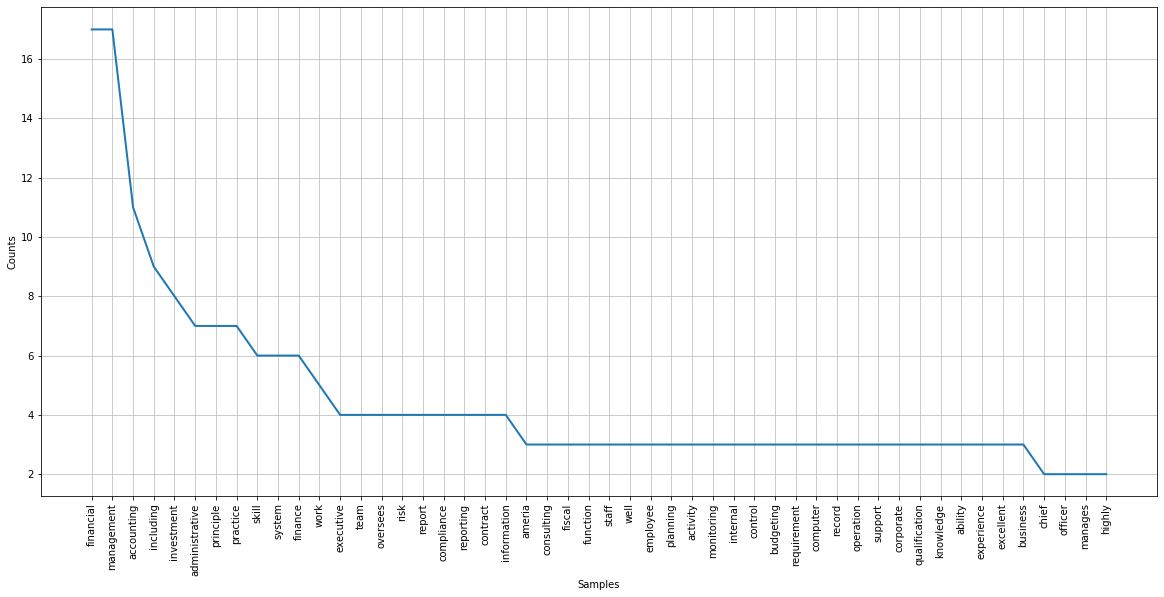

In [95]:
# plot effect of preprocessing on the a sample column
plt.figure(figsize=(20, 9))
fd = nltk.FreqDist(job_data.jobpost[0])  # case sensitive!
fd.most_common(50)
fd.plot(50)
plt.show()

    Here we can verfiy that all the preprocessing steps have been performed successfully on the jobpost columns
    
##### restricting only words having POS tagging of Nouns and Verbs 

In [98]:
def extract_nouns_verbs(tokens):
    pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ']}
    
    pos_tagged_tokens = nltk.pos_tag(tokens)
        
    nouns = [word for word,pos in filter(lambda x:x[1] in pos_family['noun'],pos_tagged_tokens)]
    nouns_text = " ".join([word for word in nouns])    
    verbs = [word for word,pos in filter(lambda x:x[1] in pos_family['verb'],pos_tagged_tokens)]
    verbs_text = " ".join([word for word in verbs])    
        
    required_pos_text = nouns_text+verbs_text
    return required_pos_text

In [99]:
job_data['jobpost_noun_verb'] = job_data.jobpost.apply(lambda x: extract_nouns_verbs(x))  # extracting nouns and verbs only

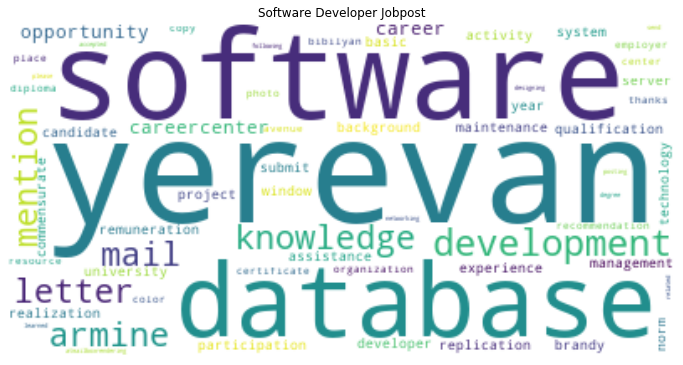

In [107]:
# lets see jobpost for a software developer i.e. indexed at 4
fig = plt.figure(figsize=(12, 8))
wc = WordCloud(background_color="white").generate((job_data.jobpost_noun_verb[4]))
plt.title("Software Developer Jobpost")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

###### creating corpus & Dictionary for the lda modelling

       here we are filtering dictionary extremes below 3 and above 70% 

In [121]:
def text_to_list(text):
    return nltk.word_tokenize(text)

In [122]:
job_data['jobpost_noun_verb'] = job_data.jobpost_noun_verb.apply(lambda x: text_to_list(x))

In [123]:
job_data

,jobpost,Title,JobDescription,JobRequirment,RequiredQual,AboutC,Year,IT,jobpost_noun_verb
0,"[ameria, investment, consulting, chief, financ...",Chief Financial Officer,AMERIA Investment Consulting Company is seekin...,- Supervises financial management and administ...,"To perform this job successfully, an\nindividu...",NaN,2004,False,"[ameria, investment, consulting, officer, yere..."
1,"[international, research, exchange, board, ire...",Full-time Community Connections Intern (paid i...,NaN,NaN,- Bachelor's Degree; Master's is preferred;\n-...,The International Research & Exchanges Board (...,2004,False,"[research, exchange, board, time, community, c..."
2,"[caucasus, environmental, network, cenn, count...",Country Coordinator,Public outreach and strengthening of a growing...,- Working with the Country Director to provide...,"- Degree in environmentally related field, or ...",The Caucasus Environmental NGO Network is a\nn...,2004,False,"[caucasus, network, country, coordinator, dura..."
3,"[manoff, group, specialist, manila, philippine...",BCC Specialist,The LEAD (Local Enhancement and Development fo...,- Identify gaps in knowledge and overseeing in...,"- Advanced degree in public health, social sci...",NaN,2004,False,"[manoff, group, specialist, description, enhan..."
4,"[yerevan, brandy, software, developer, yerevan...",Software Developer,NaN,- Rendering technical assistance to Database M...,- University degree; economical background is ...,NaN,2004,True,"[yerevan, brandy, software, developer, yerevan..."
...,...,...,...,...,...,...,...,...,...
18996,"[senior, creative, designer, term, full, time,...",Senior Creative UX/ UI Designer,A tech startup of Technolinguistics based in N...,- Work closely with product and business teams...,- At least 5 years of experience in Interface/...,As a company Technolinguistics has a mandate t...,2015,False,"[designer, term, time, duration, term, yerevan..."
18997,"[coca, cola, hellenic, bottling, cjsc, categor...",Category Development Manager,NaN,- Establish and manage Category Management dev...,"- University degree, ideally business related;...",NaN,2015,False,"[coca, cola, category, development, manager, t..."
18998,"[coca, cola, hellenic, bottling, cjsc, operati...",Operational Marketing Manager,NaN,"- Develop, establish and maintain marketing st...","- Degree in Business, Marketing or a related f...",NaN,2015,False,"[coca, cola, marketing, manager, term, time, e..."
18999,"[lazzaro, head, online, sale, duration, long, ...",Head of Online Sales Department,San Lazzaro LLC is looking for a well-experien...,- Handle the project activites of the online s...,- At least 1 year of experience in online sale...,San Lazzaro LLC works with several internation...,2015,False,"[head, sale, duration, term, yerevan, descript..."


In [124]:
dictionary = corpora.Dictionary(job_data.jobpost_noun_verb)
dictionary.filter_extremes(no_below=3, no_above=0.7)   # filtering extremes

corpus = [dictionary.doc2bow(jobpost) for jobpost in job_data.jobpost_noun_verb]

In [125]:
print(corpus[:1])

[[(0, 3), (1, 1), (2, 1), (3, 11), (4, 1), (5, 1), (6, 3), (7, 1), (8, 1), (9, 2), (10, 3), (11, 2), (12, 2), (13, 2), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 3), (27, 3), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 4), (37, 3), (38, 1), (39, 3), (40, 4), (41, 3), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 2), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 2), (54, 1), (55, 1), (56, 2), (57, 2), (58, 1), (59, 1), (60, 1), (61, 1), (62, 3), (63, 1), (64, 1), (65, 1), (66, 2), (67, 2), (68, 4), (69, 1), (70, 1), (71, 1), (72, 1), (73, 6), (74, 1), (75, 3), (76, 2), (77, 1), (78, 1), (79, 2), (80, 1), (81, 2), (82, 1), (83, 9), (84, 1), (85, 4), (86, 1), (87, 1), (88, 1), (89, 8), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 2), (96, 1), (97, 1), (98, 2), (99, 2), (100, 1), (101, 2), (102, 17), (103, 1), (104, 2), (105, 2), (106, 1), (107, 1), (108, 1), (109, 2), (110, 

* Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id,word_frequency).
* For example, (0, 3) above implies, word id 0 occurs thrice in the first document. Likewise,(1,1) word id 1 occurs once and so on.

##### find the best number of topics  in the LDA Model based on coherence score and perplexity of model
       Lets try number of topics from 6 to 10

In [127]:
def best_LDA_model(dictionary,corpus, texts, limit, start=2, step=2):
    coherence_values = []
    perplexity_scores = []
    model_list = []
    for num_topics in range(start, limit, step):  #iterate through different number of topics 
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary , random_state=121)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_scores.append(model.log_perplexity(corpus))

    return model_list, coherence_values , perplexity_scores

In [128]:
# creating different models on number of topics ranging from 6 to 10
model_list, coherence_values, perplexity_scores  = best_LDA_model(dictionary=dictionary, 
                                                                            corpus=corpus, texts=job_data.jobpost_noun_verb,
                                                                            start=6, limit=11, step=1)

###### To get the best result from LDA Model , we require the best value of num_topics which provides
* 1. low perplexity
* 2. high coherence 

Lets visualize different model results to get the desired number of topics

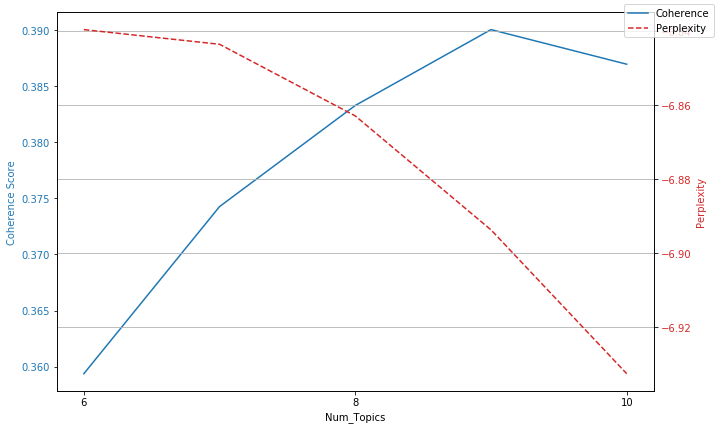

In [130]:
x = range(6,11)
fig, ax1 = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)

color = 'tab:blue'
ax1.set_xlabel('Num_Topics')
ax1.set_ylabel('Coherence Score', color=color)
ax1.plot(x, coherence_values, "-",color = color, label = 'Coherence')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(0, 50, 2))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Perplexity', color=color)
ax2.plot(x, perplexity_scores,"--" ,color = color, label = 'Perplexity')
ax2.tick_params(axis='y', labelcolor=color)

plt.grid(True)
fig.legend()
fig.tight_layout() 
plt.show()

##### num_topics = 9 has highest coherence & low perplexity as compared to others

In [132]:
optimal_lda_model = model_list[-2]  # as num_topic =9 is indexed at -2
print('num_topic',optimal_lda_model.num_topics) # to verify num topics
 
joblib.dump(optimal_lda_model,"optimal_lda_model.pkl")  # saving model output

num_topic 9


['optimal_lda_model.pkl']

In [133]:
optimal_lda_model.print_topics(num_words = 10)

[(0,
  '0.030*"software" + 0.030*"development" + 0.022*"design" + 0.019*"team" + 0.016*"ability" + 0.013*"developer" + 0.013*"term" + 0.012*"system" + 0.012*"candidate" + 0.012*"test"'),
 (1,
  '0.027*"development" + 0.022*"program" + 0.018*"community" + 0.012*"child" + 0.012*"project" + 0.012*"ability" + 0.011*"activity" + 0.011*"support" + 0.010*"ensure" + 0.009*"world"'),
 (2,
  '0.026*"course" + 0.015*"student" + 0.015*"medium" + 0.011*"business" + 0.010*"level" + 0.009*"class" + 0.009*"program" + 0.009*"office" + 0.008*"candidate" + 0.008*"duration"'),
 (3,
  '0.019*"bank" + 0.016*"business" + 0.014*"candidate" + 0.013*"management" + 0.012*"service" + 0.011*"ability" + 0.010*"credit" + 0.010*"form" + 0.010*"cjsc" + 0.009*"year"'),
 (4,
  '0.040*"sale" + 0.035*"customer" + 0.022*"product" + 0.016*"service" + 0.014*"ability" + 0.013*"manager" + 0.012*"marketing" + 0.010*"market" + 0.009*"team" + 0.009*"term"'),
 (5,
  '0.010*"education" + 0.008*"activity" + 0.008*"year" + 0.008*"pol

 #### Deriving Nature of Jobs from each topics
    Topic0: Software Development
    Topic1: Community & world
    Topic2: Student Program
    Topic3: Business Management
    Topic4: Sales & Marketing
    Topic5: Education & Research
    Topic6: Communication
    Topic7: Project Management and Development
    Topic8: Accounting & Finance
    
###### Lets visualize these topics

In [135]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.068835 -0.039496       1        1  17.993107
0     -0.178447 -0.046234       2        1  16.075129
3      0.015792  0.105052       3        1  14.125462
6     -0.071941  0.017209       4        1  14.068715
4     -0.113688  0.034945       5        1   9.692606
1      0.082455 -0.099075       6        1   9.163351
5      0.137620 -0.031615       7        1   8.694269
8      0.058911  0.179866       8        1   5.420725
2      0.000463 -0.120651       9        1   4.766639, topic_info=            Term          Freq         Total Category  logprob  loglift
3     accounting   8375.000000   8375.000000  Default  30.0000  30.0000
659         sale   9407.000000   9407.000000  Default  29.0000  29.0000
650     customer  10837.000000  10837.000000  Default  28.0000  28.0000
1273        bank   9425.000000   9425.000000  Default  27.0000  27.0000
278      project  24209.000000  24209.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
287        start    502.886871   6064.955078   Topic9  -5.3277   0.5536
13         apply    486.020691   4723.998047   Topic9  -5.3618   0.7694
0        ability    561.992371  25699.117188   Topic9  -5.2166  -0.7792
195         year    504.616241  16114.028320   Topic9  -5.3243  -0.4201
99          mail    473.436951   7462.893066   Topic9  -5.3880   0.2858

[816 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
0         1  0.158799         ability
0         2  0.222576         ability
0         3  0.130433         ability
0         4  0.182263         ability
0         5  0.115140         ability
...     ...       ...             ...
6193      5  0.050382        zeppelin
6193      7  0.003599        zeppelin
7880      1  0.990591  zusammenarbeit
7880      7  0.006077  zusammenarbeit
5829      5  0.968027       zvartnots

[3124 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 1, 4, 7, 5, 2, 6, 9, 3])

       * There is a overlap in topic 4 & 5 , which means that Education & Research has some features of Sales & Marketing
       * Similarly there is a similarity between 1(community world) & 6(communication) as obvious from the both terms

###### get dominant topic  & topic keywords from each of the document 

In [136]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    return(sent_topics_df)

In [147]:
# getting dominant topics from each documents
df_dominant_Topic = format_topics_sentences(ldamodel=optimal_lda_model,corpus=corpus,texts=job_data.jobpost_noun_verb)

# adding topic in the original data 
lda_topic_final = pd.concat([job_data,df_dominant_Topic], axis = 1)

lda_topic_final.to_csv("lda_topic_dataset.csv")  #saving final lda dataset   
df_dominant_Topic.to_csv("df_dominant_Topic.csv")

In [141]:
df_dominant_Topic

,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,7.0,0.4771,"project, management, development, ensure, abil..."
1,2.0,0.5457,"course, student, medium, business, level, clas..."
2,1.0,0.6027,"development, program, community, child, projec..."
3,7.0,0.6080,"project, management, development, ensure, abil..."
4,0.0,0.3420,"software, development, design, team, ability, ..."
...,...,...,...
18887,0.0,0.6983,"software, development, design, team, ability, ..."
18888,4.0,0.4246,"sale, customer, product, service, ability, man..."
18889,4.0,0.4358,"sale, customer, product, service, ability, man..."
18890,4.0,0.5491,"sale, customer, product, service, ability, man..."


###### Lets visualize Topic distribution in the whole data

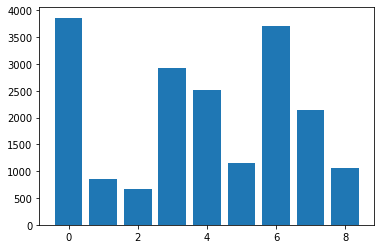

In [146]:
plt.bar(df_dominant_Topic.Dominant_Topic.value_counts().index,df_dominant_Topic.Dominant_Topic.value_counts())
plt.show()

     * Most jobs has topics Software Development & Communication 
     * while, Student Program is available least in the jobs

* ### 1.2.1  Job Nature changing over different time period

In [148]:
# define period using udf created in previous section
lda_topic_final['period'] = lda_topic_final.Year.apply(lambda x: period_by_year(x))

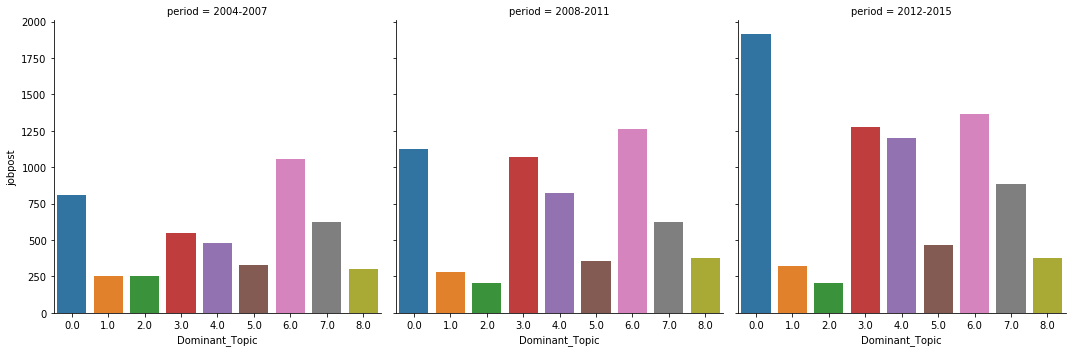

In [151]:
grouped_data = lda_topic_final.groupby(['period','Dominant_Topic']).jobpost.count().reset_index()


sns.catplot(x= 'Dominant_Topic',y='jobpost', col = 'period' , data = grouped_data , kind = 'bar')
plt.show()

    * Topic 0 - Software Development is coming most of the jobpost in the period 2012-2015 , otherwise in other period it was topic-6 i.e. Communication
    * Topic 2 - Student program is coming least in each of the period 

----------------------------------------------------------------------------------

# 2. Supervised Learning
----------------------------------------------------------------------------------------------------
* ## 2.1 : Classification
       
    ### Objective - IT JOB CLASSIFICATION

    To classify if a job posting is related to IT sector or not

    In order to classify whether a job posting is IT job or not , we used two columns from the dataset "jobpost" as the text corpus and "IT" as label

##### Define Y variable

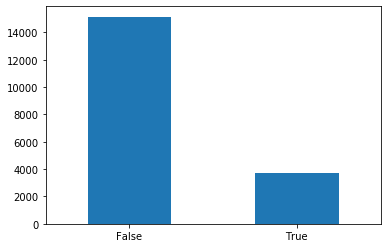

In [152]:
job_data.IT.value_counts().plot(kind= 'bar')
plt.xticks(rotation =0)
plt.show()

In [153]:
# lets convert labels of IT into 0's and 1's
job_data['IT'] = np.where(job_data.IT ==True ,1,0)
y = job_data.IT

##### Define X variable

    As jobpost column is already pre-processed in the previous section , hence we can use it directly

In [162]:
# I am using combination of Title , JobDescription 
#or else we can use jobpost column
X = job_data.jobpost

X = X.apply(lambda x: list_to_text(x))

##### Train-test Split

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3 , random_state = 1111)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13224,)
(5668,)
(13224,)
(5668,)


##### Vectorize X data

In [165]:
#Train
tfidf_vect = TfidfVectorizer( analyzer='word',
                             max_df=0.9,
                             min_df=0.005, 
                             max_features=2000,
                             stop_words='english')
X_train_tfidf = tfidf_vect.fit_transform(X_train)
#test
X_test_tfidf = tfidf_vect.transform(X_test)

dtm_train = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vect.get_feature_names())
dtm_test = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf_vect.get_feature_names())

In [168]:
dtm_train.shape

(13224, 2000)

#### Model Building

In [169]:
# building UDF to perform classification on different models
def binomial_Classfier(model_func,X_tr, y_tr, X_ts, y_ts):
    #the function assumes labels named as y_test & y_train: hence no need to input them as an argument 
    model = model_func.fit(X_tr,y_train)
    
    return [metrics.accuracy_score( y_tr ,model.predict(X_tr)),metrics.accuracy_score(y_ts ,model.predict(X_ts)), model]

In [170]:
logreg = binomial_Classfier(LogisticRegression(), dtm_train, y_train,dtm_test,y_test)  # logistic regression

In [171]:
gnb = binomial_Classfier(GaussianNB(),  dtm_train, y_train,dtm_test,y_test)   # naive bayes

In [172]:
rf = binomial_Classfier(RandomForestClassifier(),  dtm_train, y_train,dtm_test,y_test)   # random forest

In [173]:
mlp = binomial_Classfier(MLPClassifier(),  dtm_train, y_train,dtm_test,y_test)  # neural network

In [176]:
svm = binomial_Classfier(LinearSVC(),  dtm_train, y_train,dtm_test,y_test) # SVM

##### compare model results

In [177]:
model_list = [logreg,gnb,rf,mlp,svm]
model_names = ['Logistic Regression','Naive Bayes' ,'Random Forest', 'ANN' ,'SVM']

In [178]:
model_comp = pd.DataFrame(data = {"Model":model_names,
                                  'Train_Score':[m[0] for m in model_list],
                                  'Test_Score' :[m[1] for m in model_list]})
model_comp

,Model,Train_Score,Test_Score
0,Logistic Regression,0.945629,0.940191
1,Naive Bayes,0.873412,0.869619
2,Random Forest,1.000000,0.955187
3,ANN,1.000000,0.943543
4,SVM,0.972021,0.952364


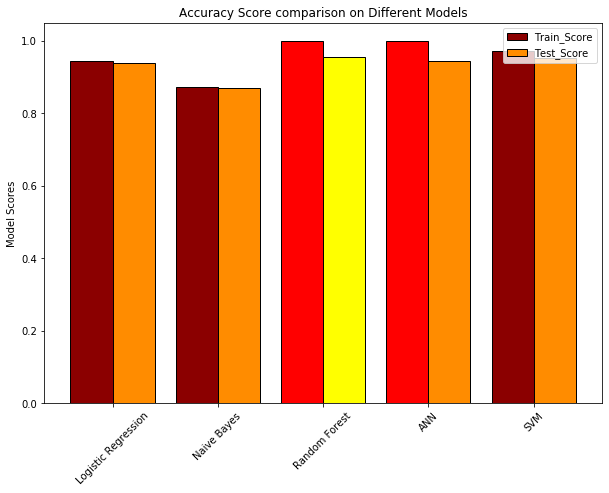

In [186]:
# VISUALIZING THE COMPARISON OF MODEL RESULT 
clr1 = ['darkred' if (x < max(model_comp.Train_Score)) else 'red' for x in model_comp.Train_Score ]
clr2 = ['darkorange' if (x < max(model_comp.Test_Score)) else 'yellow' for x in model_comp.Test_Score ]
model_comp.plot.bar(figsize=(10,7), color = [clr1,clr2],ec = 'Black', width= 0.8)
plt.title("Accuracy Score comparison on Different Models")
plt.xticks(np.arange(5),model_names,rotation = 45)
plt.ylabel("Model Scores")
plt.show()

*    **Random Forest Classifier**(shown in lighter shade in above figure) is giving best Train & Test score
* lets do some parameter tweaking in the model

In [187]:
param_grid = {'n_estimators':[100,150,200,300,400,500],
              'max_features':[10,15,20]}

grid_rf = GridSearchCV(estimator= RandomForestClassifier(),
                      param_grid=param_grid,
                      cv = 3,
                      n_jobs=-1)

In [188]:
grid_rf.fit(dtm_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [190]:
grid_rf.best_params_

{'max_features': 20, 'n_estimators': 400}

In [191]:
best_model_grid = grid_rf.best_estimator_   # rf model with parameter tuning
best_model_default = rf[2]        # best rf model with default parameters

#### lets see comparison in the model with default parameter and the model with gridsearchCV

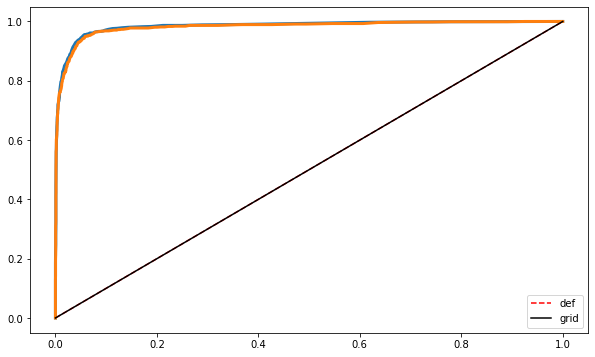

In [196]:
plt.figure(figsize  = (10,6))
fpr,tpr, threshold = metrics.roc_curve(y_test,best_model_default.predict_proba(dtm_test)[:,1]) # model with default parameter
fpr1,tpr1, threshold1 = metrics.roc_curve(y_test,best_model_grid.predict_proba(dtm_test)[:,1])  # model with tuned parameter
plt.plot(fpr,tpr, linewidth = 3)
plt.plot([0,1],[0,1],'k--', label ='def',c='red')
plt.plot(fpr1,tpr1, linewidth = 3)
plt.plot([0,1],[0,1],'k-', label ='grid')
plt.legend()
plt.show()

    No difference found , both the models have covered same area under the roc_curve

In [197]:
# considering model with default parameters as the best model
best_classif_model = best_model_default
joblib.dump(best_classif_model, "best_IT_classif_model.pkl")

['best_IT_classif_model.pkl']

##### Model Validation


##### 1. Precision /Recall Curve 

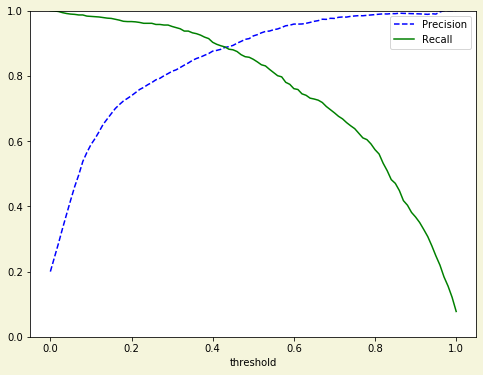

In [199]:
def plot_prec_recall_vs_thresh(pr, rc, th, figsize = (8,6)):
    plt.figure(figsize = figsize,facecolor = 'beige')
    plt.plot(th,pr[:-1],"b--", label = 'Precision')
    plt.plot(th,rc[:-1],"g-", label ="Recall")
    plt.xlabel("threshold")
    plt.ylim([0,1])
    plt.legend()
    plt.show()
    
precision , recall , thresh = metrics.precision_recall_curve(y_test,best_classif_model.predict_proba(dtm_test)[:,1])
plot_prec_recall_vs_thresh(pr=precision,rc = recall,th =thresh)

###### 2.Confusion Matrix

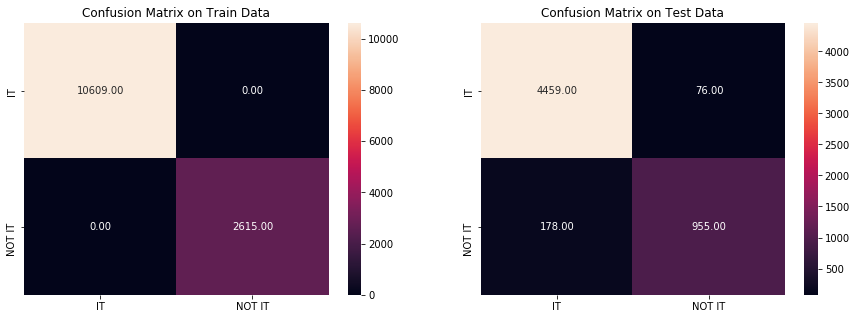

In [201]:
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
g1 = sns.heatmap(metrics.confusion_matrix(y_train,best_classif_model.predict(dtm_train)),annot = True, fmt='.2f', 
                 ax=ax, xticklabels=['IT', 'NOT IT'], yticklabels=['IT', 'NOT IT']) 
g1.set_title("Confusion Matrix on Train Data")
g2 = sns.heatmap(metrics.confusion_matrix(y_test,best_classif_model.predict(dtm_test)),annot = True, fmt='.2f', ax=ax2,
                xticklabels=['IT', 'NOT IT'], yticklabels=['IT', 'NOT IT'])
g2.set_title("Confusion Matrix on Test Data")
plt.show()

     * model predicted 76 IT jobs as Non-IT jobs 
     * With the help precision/recall curve we can predict more recall or more precision based on different thresholds
     
###### 3. Classification Report

In [203]:
print(metrics.classification_report(y_test, best_classif_model.predict(dtm_test)))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4535
           1       0.93      0.84      0.88      1133

    accuracy                           0.96      5668
   macro avg       0.94      0.91      0.93      5668
weighted avg       0.95      0.96      0.95      5668



* ## 2.1.1 -  Top Keywords in Job Description to classify between an IT or Non IT job

In [205]:
Feature_rank = pd.DataFrame([x for x in zip(dtm_train.columns , best_classif_model.feature_importances_)], 

                            columns= ['features','importance']).sort_values(by = 'importance',ascending = False)

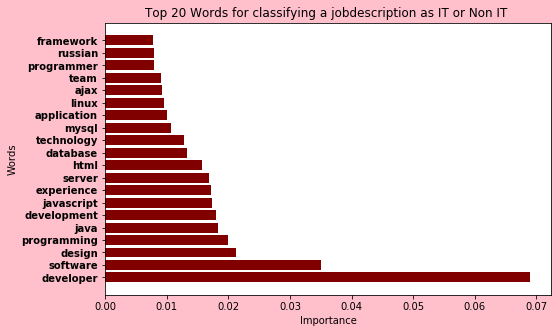

In [208]:
%matplotlib inline
plt.figure(figsize =(8,5), facecolor="pink")
plt.title("Top 20 Words for classifying a jobdescription as IT or Non IT ")
plt.barh(Feature_rank.features[:20],Feature_rank.importance[:20], color='maroon')
plt.xlabel("Importance")
plt.yticks(fontweight = 'bold')
plt.ylabel("Words")
plt.show()

* lets view all words on a wordcloud

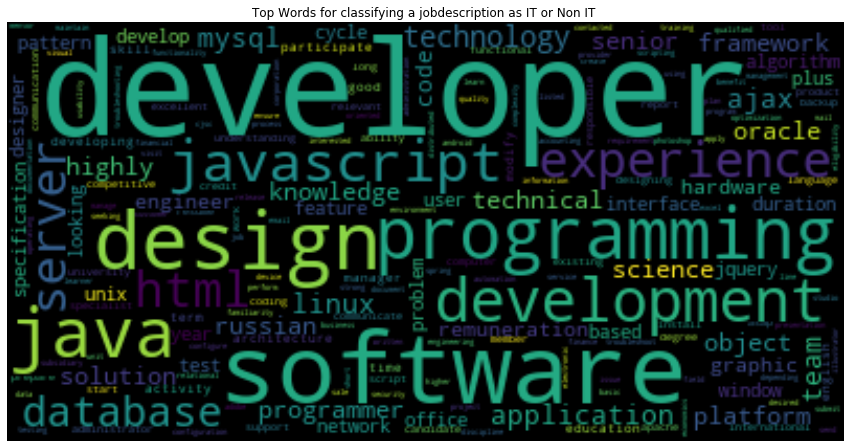

In [209]:
d = {}
for a, x in Feature_rank.values:
    d[a] = x

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(15, 12))
plt.title("Top Words for classifying a jobdescription as IT or Non IT ")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Conclusion:
   * Job Description containing words like **"developer','software','design','database','java' etc** can classify a job as an IT related job

--------------------------------------------------------------------------------------

# 3. Information Extraction
---------------------------------------------------------------------------------------------------
       
   ### Objective - Similarity of Jobs
   Find the 5 top jobs that are of similar nature , based on the jobpost

In [212]:
#extracting selective columns to find similarity in the dataset
df_similarity = job_data[['Title','JobDescription','RequiredQual','JobRequirment']]

In [11]:
df_similarity['JobDescription'] = df_similarity['JobDescription'].astype(str)
df_similarity['RequiredQual'] = df_similarity['RequiredQual'].astype(str)
df_similarity['JobRequirment'] = df_similarity['JobRequirment'].astype(str)
df_similarity['Title'] = df_similarity['Title'].astype(str)

In [12]:
df_similarity.isna().sum()

Title             0
JobDescription    0
RequiredQual      0
JobRequirment     0
dtype: int64

In [218]:
# preprocess Title column
df_similarity['Title'] = df_similarity.Title.apply(lambda x: pre_process(x)) #tokenize,remove punctuation & stopwords
df_similarity['Title'] = df_similarity.Title.apply(lambda x: make_bigrams(x)) # bigrams
df_similarity['Title'] = df_similarity.Title.apply(lambda x: make_trigrams(x)) # trigrams
df_similarity['Title'] = df_similarity.Title.apply(lambda x: lemmatization(x))  #lemmatization

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [219]:
# preprocess RequiredQual column
df_similarity['RequiredQual'] = df_similarity.RequiredQual.apply(lambda x: pre_process(x)) #tokenize,remove punctuation & stopwords
df_similarity['RequiredQual'] = df_similarity.RequiredQual.apply(lambda x: make_bigrams(x)) # bigrams
df_similarity['RequiredQual'] = df_similarity.RequiredQual.apply(lambda x: make_trigrams(x)) # trigrams
df_similarity['RequiredQual'] = df_similarity.RequiredQual.apply(lambda x: lemmatization(x))  #lemmatization

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [220]:
# preprocess JobRequirment column
df_similarity['JobRequirment'] = df_similarity.JobRequirment.apply(lambda x: pre_process(x)) #tokenize,remove punctuation & stopwords
df_similarity['JobRequirment'] = df_similarity.JobRequirment.apply(lambda x: make_bigrams(x)) # bigrams
df_similarity['JobRequirment'] = df_similarity.JobRequirment.apply(lambda x: make_trigrams(x)) # trigrams
df_similarity['JobRequirment'] = df_similarity.JobRequirment.apply(lambda x: lemmatization(x))  #lemmatization

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [221]:
# preprocess JobDescription column
df_similarity.loc[:,'JobDescription'] = df_similarity.JobDescription.apply(lambda x: pre_process(x)) #tokenize,remove punctuation & stopwords
df_similarity.loc[:,'JobDescription'] = df_similarity.JobDescription.apply(lambda x: make_bigrams(x)) # bigrams
df_similarity.loc[:,'JobDescription'] = df_similarity.JobDescription.apply(lambda x: make_trigrams(x)) # trigrams
df_similarity.loc[:,'JobDescription'] = df_similarity.JobDescription.apply(lambda x: lemmatization(x))  #lemmatization

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [226]:
# convert list to string
df_similarity['Title'] = df_similarity.Title.apply(lambda x: list_to_text(x)) 
df_similarity['JobDescription'] = df_similarity.JobDescription.apply(lambda x: list_to_text(x)) 
df_similarity['JobRequirment'] = df_similarity.JobRequirment.apply(lambda x: list_to_text(x)) 
df_similarity['RequiredQual'] = df_similarity.RequiredQual.apply(lambda x: list_to_text(x)) 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [230]:
df_similarity.to_csv("df_similarity.csv") # saving cleaned dataset

----------------------------------------------------------------------------------------------------
* ### 3.1 : TF-IDF Based Similarity

In [231]:
tfidf_vect = TfidfVectorizer(analyzer='word',
                             max_df=0.7,
                             min_df=3, 
                             max_features=2000,
                             stop_words='english')

In [238]:
Title_tfidf = tfidf_vect.fit_transform(df_similarity['Title'])
JobDescription_tfidf = tfidf_vect.fit_transform(df_similarity['JobDescription'])
RequiredQual_tfidf = tfidf_vect.fit_transform(df_similarity['RequiredQual']) 
JobRequirment_tfidf = tfidf_vect.fit_transform(df_similarity['JobRequirment'])

In [298]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_jobs(title,top_n = 5):   # to get top 5 similar jobs
    index = df_similarity[df_similarity.Title == title].index[0]   # get index of given title in the datset
    
    Title_cos = cosine_similarity(Title_tfidf[index:index+1], Title_tfidf).flatten()
    JobDescription_cos = cosine_similarity(JobDescription_tfidf[index:index+1], JobDescription_tfidf).flatten()
    RequiredQual_cos= cosine_similarity(RequiredQual_tfidf[index:index+1], RequiredQual_tfidf).flatten()
    JobRequirment_cos= cosine_similarity(JobRequirment_tfidf[index:index+1], JobRequirment_tfidf).flatten()

    average_cosine = (Title_cos + JobDescription_cos + RequiredQual_cos + JobRequirment_cos) / 4.0
    related_docs_indices = [i for i in average_cosine.argsort()[::-1] if i != index]
    
    output_df = pd.DataFrame(columns = ['index_at_df','similarity_score','Title','JobDesc','ReqdQual','JobReq'])
    
    for n in range(top_n):
        for index,score in [(index, average_cosine[index]) for index in related_docs_indices][:n+1]:
            details = df_similarity.iloc[index]
            output_df.loc[n] = [index, score, details.loc['Title'], details.loc['JobDescription'], details.loc['RequiredQual'], details.loc['JobRequirment'] ]
        
    return output_df

In [304]:
df_similarity.Title.value_counts().head(10)

developer                   404
accountant                  328
software developer          289
medical representative      226
chief accountant            220
engineer                    209
senior developer            185
sale manager                170
administrative assistant    158
lawyer                      154
Name: Title, dtype: int64

In [294]:
find_similar_jobs('chief financial officer')

,index_at_df,similarity_score,Title,JobDesc,ReqdQual,JobReq
0,7873,0.500925,chief financial officer,full authority responsibility establishing mea...,master degree business administration finance ...,among also ensure compliance deal local state ...
1,5834,0.495470,chief financial officer,full authority responsibility establishing mea...,master degree business administration finance ...,ensure compliance deal local state finance rel...
2,12290,0.493793,chief financial officer,chief financial officer support chief executiv...,degree accounting finance business public admi...,financial management nsrcip project preparatio...
3,11153,0.477053,chief financial officer,river island seeking chief financial officer r...,master degree management finance economics lea...,develop tool system provide critical financial...
4,8081,0.472700,chief financial officer,gritti inviting highly qualified professional ...,master equivalent university degree finance ac...,general assist performing task necessary achie...


In [300]:
find_similar_jobs('software developer')

,index_at_df,similarity_score,Title,JobDesc,ReqdQual,JobReq
0,8765,0.377646,software developer,lsoft seeking qualified experienced candidate ...,least year work experience software developer ...,participate software database design communica...
1,9488,0.366334,software developer,lsoft looking qualified experienced candidate ...,least year work experience software developer ...,participate software database design effective...
2,15292,0.364263,software developer,betarchitect looking software developer knowle...,computer science related technical field least...,participate software database design communica...
3,15176,0.364263,software developer,betarchitect looking software developer knowle...,computer science related technical field least...,participate software database design communica...
4,7596,0.359276,software developer,lsoft seeking qualified experienced candidate ...,least year work experience software developer ...,participate software database design effective...


In [302]:
find_similar_jobs('accountant')

,index_at_df,similarity_score,Title,JobDesc,ReqdQual,JobReq
0,6021,0.234757,trainer,trainer responsible developing planning conduc...,higher education pedagogy psychology sociology...,regularly conduct training need assessment sta...
1,1974,0.219442,business trainer management,within area specialization seek professional b...,relevant degree business management relevant t...,prepare training material powerpoint presentat...
2,16573,0.205664,trainer consultant,heifer project international seeking local exp...,flexibility readiness invest innovation modifi...,develop provide training curriculum manual ada...
3,8573,0.204660,corporate trainer,rosgosstrakh icjsc looking corporate trainer r...,higher education least year work experience or...,organize conduct training according corporate ...
4,11991,0.197944,corporate trainer,rosgosstrakh icjsc looking corporate trainer r...,higher education least year work experience or...,organize conduct training according corporate ...


    with low scores ,job similarity are not that relevent

In [306]:
find_similar_jobs('chief accountant')

,index_at_df,similarity_score,Title,JobDesc,ReqdQual,JobReq
0,7915,0.413983,chief accountant,irtek cjsc looking chief accountant incumbent ...,university degree accounting finance least yea...,include limited following provide support oper...
1,7835,0.413066,chief accountant,reso cjsc looking chief accountant incumbent t...,university degree accounting finance least yea...,include limited following provide support oper...
2,7544,0.408765,chief accountant,newplast cjsc looking chief accountant incumbe...,university degree accounting finance year expe...,include limited following provide support oper...
3,7499,0.404688,chief accountant,fondex commercial looking chief accountant inc...,university degree accounting finance year expe...,include limited following provide support oper...
4,859,0.402796,chief accountant,chief accountant supervised financial director,university degree accounting finance russian l...,preparate monthly annual financial report mana...


In [311]:
find_similar_jobs('country coordinator')

,index_at_df,similarity_score,Title,JobDesc,ReqdQual,JobReq
0,403,0.377301,country coordinator,cenn caucasus environmental network looking co...,education university education environmental s...,write first hand article conduct interview col...
1,13410,0.314571,country coordinator,veya limited need experienced business manager...,university degree middle east study internatio...,coordinate activity office staff middle east c...
2,292,0.295361,country coordinator russia azerbaijan,country coordinator report directly region man...,minimum education public administration social...,essential duty include limited following commu...
3,18798,0.280900,country coordinator,veya looking qualified country coordinator abl...,least year experience project management excep...,negotiate potential customer lobby support pro...
4,10719,0.271048,environmental coordinator,environmental coordinator performs cross secti...,higher education economics technical field eco...,organize environmental committee meeting coord...


----------------------------------------------------------------------------------------------